In [2]:
import cv2
import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm_notebook as tqdm


In [3]:
data = []
with open('../darknet/predictions.txt','r') as f:
    for line in f.readlines():
        if line.startswith('Enter'):
            img_path = line.split('Path: ')[-1].split(': Predicted')[0].strip()
        if line.startswith('HWR'): 
            _type = 'HWR'
        elif line.startswith('QR'):
            _type = 'QR'
        elif line.startswith('Mix'):
            _type = 'Mix'
        elif line.startswith('OCR'):
            _type = 'OCR'
        if line.startswith('HWR') | line.startswith('QR') | line.startswith('Mix') | line.startswith('OCR'):
            if 'left_x' in line:
                _type = line.split(':')[0]
                certainty = int(line.split(':')[1].split('%')[0].strip())/100
                lx = int(line.split('left_x:')[1].split('top_y')[0].strip())
                ty = int(line.split('top_y:')[1].split('width')[0].strip())
                w = int(line.split('width:')[1].split('height')[0].strip())
                h = int(line.split('height:')[1].split(')')[0].strip())
                data += [[img_path,lx,ty,w,h,_type]]
        else:
            pass

In [4]:
y_filter = np.ones((9,9))
y_filter[:4] = -1
y_filter[4] = 0

def rotate_bound(image, angle, borderValue):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderValue=(borderValue,borderValue,borderValue))

def sobel(img, dx, dy, ksize):
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,dx,dy,ksize=ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    return np.uint8(abs_sobel64f)

def get_consecutive_coords_above_threshold(sobel_xy, height, width, squ_size, threshold):
    consecutive = 0 
    consecutive_coords = []
    text_coords = []
    for j in range(height//squ_size):
        sy = j*squ_size
        ey = j*squ_size + squ_size
        for i in range(width//squ_size):
            sx = i*squ_size
            ex = i*squ_size + squ_size

            squ = sobel_xy[sy:ey,sx:ex]

            _mean = squ.mean()
            if _mean >= threshold:
                consecutive += 1
                consecutive_coords += [(sx,sy,ex,ey)]

            elif consecutive >= 0:
                if consecutive >= min_consecutive:
                    consecutive = 0
                    text_coords += consecutive_coords
                else:
                    consecutive = 0
                    consecutive_coords = []

        if consecutive >= min_consecutive:
            text_coords += consecutive_coords
        consecutive_coords = []
        consecutive = 0
    
    return text_coords

def plot_rectangles(img, rectangles, colors=False):
    if not colors:
        messy = img.copy()
        for (startX, startY, endX, endY) in rectangles:
            cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    if colors:
        colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255),(100,100,100)]
        messy = img.copy()
        color = 0
        for label in rectangles:
            for (startX, startY, endX, endY) in label:
                cv2.rectangle(messy, (startX, startY), (endX, endY), colors[color], 2)
            color += 1
            if color == len(colors):
                color = 0
    plt.figure()
    plt.imshow(messy)
    
def group_squares_into_labels(coords, max_dist_btw, min_squ_per_label):
    coords_stack = coords.copy()

    labels = []
    while len(coords_stack):
        squ1 = coords_stack[0]
        sx1, sy1, ex1, ey1 = squ1
        mx1 = (sx1+ex1)/2
        my1 = (sy1+ey1)/2

        new_label = []
        to_be_checked = [squ1]
        coords_stack.remove(squ1)

        while len(to_be_checked):
            squ1 = to_be_checked[0]
            sx1, sy1, ex1, ey1 = squ1
            mx1 = (sx1+ex1)/2
            my1 = (sy1+ey1)/2

            new_label += [squ1]
            to_be_checked.remove(squ1)

            coords_stack2 = coords_stack.copy()
            for i in range(len(coords_stack2)):
                squ2 = coords_stack2[i]
                sx2, sy2, ex2, ey2 = squ2
                mx2 = (sx2+ex2)/2
                my2 = (sy2+ey2)/2
                dist = np.sqrt((mx1-mx2)**2 + (my1-my2)**2)
                if dist <= max_dist_btw:
                    to_be_checked += [squ2]
                    coords_stack.remove(squ2)
        if len(new_label) >= min_squ_per_label:
            labels += [new_label]
            
    return labels

In [34]:
padding = 15
debug = False
from glob import glob
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
df = pd.DataFrame(data,columns=['lowres_fp','lx','ty','w','h','type'])#.to_csv('lowres_aarhus_bounding_boxes.csv')
print(len(df))
df['dataset'] = df['lowres_fp'].map(lambda x: 'Aarhus' if 'Aarhus' in x else 'zooniverse')
i = 0

squ_size = 7
assert squ_size%2 == 1
max_dist_btw = squ_size*2.4
min_consecutive = 3
min_squ_per_label = 40
threshold = 10
if debug == True:
    df = df.sample(frac=0.1)
    

9866


In [35]:
df = df[df['lowres_fp'].map(lambda x: 'zooniverse' in x)]

In [36]:
for name,group in tqdm(df.groupby('lowres_fp'),total=len(df['lowres_fp'].drop_duplicates())):
    i = 0
    fp = name
    dataset = group['dataset'].iloc[0]
    img = cv2.imread(fp)
    orig_h,orig_w = img.shape[:2]
    img = cv2.resize(img,(1024,768))
    orig = img
    img = cv2.GaussianBlur(img, (11,11), 3)
    for _, row in group.iterrows():
        sx = int(max(row['ty'] - padding,0)//(orig_h/768))
        sy = int(max(row['lx'] - padding,0)//(orig_w/1024))
        ex = int(min(row['h'] + row['ty'] + padding, orig_h)//(orig_h/768))
        ey = int(min(row['w'] + row['lx'] + padding, orig_w)//(orig_w/1024))
        _type = row['type']
        if dataset == 'Aarhus':
            cat_no = fp.split('-')[2]
            out_path = '/home/rob/HWR/datasets/Aarhus/yolo_labels/' + cat_no + '_' + str(i) + '_' + _type + '.jpg'
        elif dataset == 'zooniverse':
            cat_no = fp.split('/')[6]
            out_path = '/home/rob/HWR/datasets/zooniverse/yolo_labels/' + cat_no + '_' + str(i) + '_' + _type + '.jpg'

        label = cv2.cvtColor(img[sx:ex,sy:ey], cv2.COLOR_BGR2GRAY)

        kmeans = KMeans(n_clusters=2, n_init=1, init=np.array([[0],[255]])).fit(np.expand_dims(label.flatten(),axis=1))
        mask = kmeans.predict(label.reshape(-1,1)).reshape(label.shape)
        label[mask == 1] = 255
        label = cv2.cvtColor(label, cv2.COLOR_GRAY2BGR)
            

        sobel_xy = sobel(label, 1, 1, 5)    

        if debug == True:
            plt.imshow(img)
            plt.figure()
            plt.imshow(sobel_xy)
        height,width = label.shape[:2]
        text_coords = get_consecutive_coords_above_threshold(sobel_xy, height, width, squ_size, threshold)
        if debug == True:
            plot_rectangles(sobel_xy, text_coords)

        labels = group_squares_into_labels(text_coords, max_dist_btw, min_squ_per_label)
        _copy = labels.copy()
        labels = []
        for _label in _copy:
            labels += _label
            
        if not len(labels):
            continue
        orig_labels = list(np.array(labels) + np.array([sy,sx,sy,sx]))
        if debug == True:
            plot_rectangles(label, [labels], colors=True)
        
        sobel_y = sobel(label, 0, 1, 3)
        sobel_y = cv2.filter2D(img, -1, y_filter)
        sobel_y = cv2.cvtColor(sobel_y, cv2.COLOR_BGR2GRAY)
        _,sobel_y = cv2.threshold(sobel_y,120,255,cv2.THRESH_BINARY)


        #sobel_y = sobel_y / 255
        max_angle = 45
        n_angles = 300
        pad = 5


        if debug == True:
            plt.figure()
            plt.imshow(img)
            plt.figure()
            plt.imshow(sobel_y)


        label_sobel = sobel_y[sx:ex,sy:ey].copy()

        
        messy = cv2.cvtColor(label_sobel, cv2.COLOR_GRAY2BGR).copy()
        thetas = []
        thres = 150
        min_len = 80
        max_gap = 20
        lines = cv2.HoughLinesP(label_sobel,1,np.pi/180,thres,300,min_len, max_gap)
        while (thres > 0) & (lines is None) & (min_len > 0):
            min_len -= 10
            thres -= 10
            max_gap += 10
            lines = cv2.HoughLinesP(label_sobel,1,np.pi/180,thres,300,min_len, max_gap)

        if lines is None:
            lines = []

        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(messy,(x1,y1),(x2,y2),(0,255,0),2)
            thetas += [np.arctan((y2-y1)/(x2-x1))]

        if len(lines):
            best_angle = np.mean(thetas)*180/np.pi
        else:
            best_angle = 0

        if debug == True:
            plt.figure()
            plt.imshow(messy)
            plt.title(best_angle)   
        

        if debug == True:
            dst = rotate_bound(orig[sx:ex,sy:ey].copy(), best_angle, borderValue=255)
            plt.figure()
            plt.imshow(dst)
            plt.title(str(best_angle))

        M = cv2.getRotationMatrix2D((0, 0), best_angle, 1.0)
        rotated_squs = [np.append([a[0],a[1]],[1]) for a in orig_labels]
        rotated_squs += [np.append([a[2],a[3]],[1]) for a in orig_labels]
        rotated_squs = np.dot(rotated_squs, M.T)
        sx = rotated_squs.min(axis=0)[1]
        sy = rotated_squs.min(axis=0)[0]
        ex = rotated_squs.max(axis=0)[1] 
        ey = rotated_squs.max(axis=0)[0]
        if debug == True:
            plot_rectangles(orig,orig_labels)

        x_offset = 0
        y_offset = 0
        if best_angle > 0:
            x_offset = np.abs((orig.shape[1])*np.sin(best_angle*np.pi/180))
        elif best_angle < 0: 
            y_offset = np.abs((orig.shape[0])*np.sin(best_angle*np.pi/180))



        nsx = int(sx + x_offset - pad)
        nsy = int(sy + y_offset - pad)
        nex = int(ex + x_offset + pad)
        ney = int(ey + y_offset + pad)
        nsx = max(nsx, 0)
        nsy = max(nsy, 0)
        nex = min(nex, orig.shape[0])
        ney = min(ney, orig.shape[1])

        aspect_ratio = (nex-nsx)/(ney-nsy)
        if aspect_ratio > 10:
            print('AR too large')
            continue

        dst = rotate_bound(orig, best_angle, borderValue=255)
        if debug == True:
            plot_rectangles(dst,[(int(sy),int(sx),int(ey),int(ex))])
            plot_rectangles(dst,[(int(nsy),int(nsx),int(ney),int(nex))])

        if debug == True:
            plt.figure()
            plt.imshow(dst[nsx:nex,nsy:ney])

        if debug == False:
            cv2.imwrite(out_path, dst[nsx:nex,nsy:ney])

            
        if debug == True:
            break


        i+=1
    

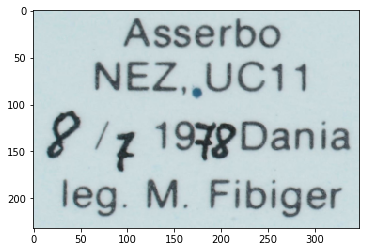

In [31]:
plt.imshow(dst[nsx:nex,nsy:ney])

(<matplotlib.image.AxesImage at 0x7f10173b6320>, 363, 721, 487, 938)

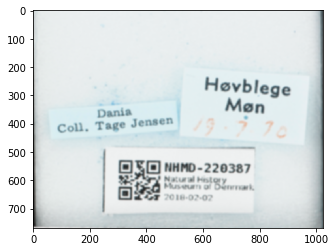

In [24]:
plt.imshow(img),sx,sy,ex,ey

In [21]:

sx = max(row['ty'] - padding,0)
sy = max(row['lx'] - padding,0)
ex = min(row['h'] + row['ty'] + padding, orig.shape[0])
ey = min(row['w'] + row['lx'] + padding, orig.shape[1])
sx,sy,ex,ey

(1923, 1121, 768, 1024)

In [22]:

sx = int(max(row['ty'] - padding,0)//(orig_h/768))
sy = int(max(row['lx'] - padding,0)//(orig_w/1024))
ex = int(min(row['h'] + row['ty'] + padding, orig_h)//(orig_h/768))
ey = int(min(row['w'] + row['lx'] + padding, orig_w)//(orig_w/1024))
sx,sy,ex,ey

(537, 329, 727, 841)

In [29]:
df['cat_no'] = df['lowres_fp'].map(lambda x: x.split('-')[2] if 'Aarhus' in x else x.split('/')[6])
df[df['cat_no']=='222064']

,lowres_fp,lx,ty,w,h,type,dataset,cat_no
9864,/home/rob/HWR/datasets/zooniverse/222064/Cropp...,902,517,1699,1065,OCR,zooniverse,222064
9865,/home/rob/HWR/datasets/zooniverse/222064/Cropp...,949,1749,2364,860,QR,zooniverse,222064


In [30]:
df

,lowres_fp,lx,ty,w,h,type,dataset,cat_no
0,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199020-...,324,177,912,462,HWR,Aarhus,199020
1,/home/rob/HWR/datasets/zooniverse/222876/Cropp...,733,2391,1570,623,QR,zooniverse,222876
2,/home/rob/HWR/datasets/zooniverse/222876/Cropp...,904,1836,1067,603,HWR,zooniverse,222876
3,/home/rob/HWR/datasets/zooniverse/222638/Cropp...,464,1260,1873,833,OCR,zooniverse,222638
4,/home/rob/HWR/datasets/zooniverse/222638/Cropp...,973,2159,2196,821,QR,zooniverse,222638
5,/home/rob/HWR/datasets/zooniverse/222638/Cropp...,2143,1276,1184,757,OCR,zooniverse,222638
6,/home/rob/HWR/datasets/zooniverse/221584/Cropp...,855,2182,2062,784,QR,zooniverse,221584
7,/home/rob/HWR/datasets/zooniverse/221584/Cropp...,971,1156,1566,918,OCR,zooniverse,221584
8,/home/rob/HWR/datasets/zooniverse/221803/Cropp...,278,2155,2160,566,OCR,zooniverse,221803
9,/home/rob/HWR/datasets/zooniverse/221803/Cropp...,285,334,1731,717,OCR,zooniverse,221803
